# Equatorial Thermal and Zonal Velocity Structure

This recipe plots various equatorial properties from ACCESS-OM2 simulations and compare to observations. All plots are currently focused on the Equatorial Pacific but can easily be adapted to the Atlantic or Indian, or to off-equatorial locations. 

Several sets of plots are included:

1) Longitude-depth and latitude-depth slices of temperature and zonal velocity compared to the Johnson et al. observations.

2) Longitude-depth temperature bias plots compared to WOA13.

3) Vertical profiles of temperature and zonal velocity at a specified horizontal location (140W, 0N below) compared to TAO, Johnson and WOA13 data.

4) Longitude-time Hovmoeller plots describing the seasonal cycle of SST (compared to WOA13) and zonal velocity (compared to drifter observations).

Results are compared to several observational products:

1) The WOA2013 climatological data set located in `/g/data/hh5/tmp/cosima/woa13`.

2) The Johnson et al. (2002, doi: 10.1016/s0079-6611(02)00021-6) observational data set located in `/g/data/ik11/observations/Johnson2002`.

3) TAO array mooring data located in `/g/data/ik11/observations/TAO`.

4) Laurindo et al. 2017 drifter data set for surface velocities located in `/g/data/hh5/tmp/cosima/observations/original/drifter_monthlymeans.nc`.

1, 2 and 4 are spatially resolved data sets, while the TAO moorings are only used for the vertical profile plotting.

### Load packages, session, workers and define experiments

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cftime
import cmocean as cm
import glob
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import sys, os
import warnings
warnings.simplefilter("ignore") 
import logging
logging.getLogger('flox').setLevel(logging.WARNING)
from dask.distributed import Client

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45351,Workers: 48
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:43055,Total threads: 1
Dashboard: /proxy/40711/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:46821,


Open ACCESS-NRI default catalog:

In [3]:
catalog = intake.cat.access_nri

Make an experiment dictionary with names of experiment to query the catalog and long names for plot labeling. Also define time bounds from which to load each experiment.

In [4]:
exp_dict = {'1degRYF': {'long_name': 'ACCESS-OM2 RYF',
                        'experiment': '1deg_jra55_ryf9091_gadi',
                        'time_bounds': slice('2420-01-01', '2425-12-31')},
            '025degRYF': {'long_name': 'ACCESS-OM2-025 RYF',
                          'experiment': '025deg_jra55_ryf9091_gadi',
                        'time_bounds': slice('2420-01-01', '2425-12-31')},
            '01degRYF': {'long_name': 'ACCESS-OM2-01 RYF',
                         'experiment': '01deg_jra55v13_ryf9091',
                         'time_bounds': slice('2120-01-01', '2125-12-31')},
            '1degIAF': {'long_name': 'ACCESS-OM2 IAF',
                        'experiment': '1deg_jra55_iaf_omip2_cycle5',
                        'time_bounds': slice('2000-01-01', '2005-12-31')},
            '025degIAF': {'long_name': 'ACCESS-OM2-025 IAF',
                          'experiment': '025deg_jra55_iaf_omip2_cycle5',
                          'time_bounds': slice('2000-01-01', '2005-12-31')}}

## Longitude-Depth and Latitude-Depth Slices compared to Johnson et al. 2002

This section includes two sets of longitude-depth and latitude-depth slices - one comparing the thermal and zonal velocity structure between ACCESS-OM2 simulations and the Johnson et al. 2002 observations, and one plotting temperature biases to the WOA13 temperature data set. These types of plots were used in the Kiss et. al GMD paper.

We start by defining the locations of our slices:

In [5]:
depths = slice(0, 400)     # depth range for all plots [m]

eq_lon_bounds = slice(-221,-79) # longitude range for longitude-depth plot [degrees]
eq_lat = 0.          # latitude for longitude-depth plot [degrees]

eq_lon = -140.        # longitude for latitude-depth plot [degrees]
eq_lon_obs = 220.      # longitude for latitude-depth plot for Johnson observations. [degrees]
eq_lat_bounds = slice(-8,10)     # latitudes for latitude-depth plot [degrees]

### Define data-extract functions for ACCESS-OM2 data:

Define two functions that extract temperature (in degC) and zonal velocity (in cms-1) data from the ACCESS-OM2 simulations defined above. This returns the climatology of 5 years of experiment. You probably want more years, but it makes the loading slower.

In [6]:
# Define function to extract temperature:
def load_temp(ekey):

    expt = exp_dict[ekey]['experiment']
    
    darray = catalog[expt].search(variable = 'temp', frequency = '1mon').to_dask(xarray_open_kwargs = {'use_cftime':True})
    darray = darray['temp'].sel(time = exp_dict[ekey]['time_bounds']) - 273.15
    darray = darray.mean('time')          
    
    upper_temp_eq = darray.sel(st_ocean = depths, xt_ocean = eq_lon_bounds).sel(yt_ocean = eq_lat, method = 'nearest') 
    upper_temp_eq = upper_temp_eq.load()
    upper_temp_eq.attrs['units'] = 'degrees Celsius'

    upper_temp_140w = darray.sel(st_ocean = depths, yt_ocean = eq_lat_bounds).sel(xt_ocean = eq_lon, method = 'nearest') 
    upper_temp_140w = upper_temp_140w.load()
    upper_temp_140w.attrs['units'] = 'degrees Celsius'
    
    return upper_temp_eq, upper_temp_140w

# Define function to extract zonal velocity:
def load_u(ekey):
    
    expt = exp_dict[ekey]['experiment']
    
    darray = catalog[expt].search(variable = 'u', frequency = '1mon').to_dask(xarray_open_kwargs = {'use_cftime': True})
    darray = darray['u'].sel(time = exp_dict[ekey]['time_bounds']) * 100 # convert m/s -> cm/s
    darray = darray.mean('time')
    
    upper_u_eq = darray.sel(st_ocean = depths, xu_ocean = eq_lon_bounds).sel(yu_ocean = eq_lat, method = 'nearest') 
    upper_u_eq = upper_u_eq.load()
    upper_u_eq.attrs['units'] = 'cm s-1'

    upper_u_140w = darray.sel(st_ocean = depths, yu_ocean = eq_lat_bounds).sel(xu_ocean = eq_lon, method = 'nearest') 
    upper_u_140w = upper_u_140w.load()
    upper_u_140w.attrs['units'] = 'cm s-1'
    
    return upper_u_eq, upper_u_140w

Load data of the RYF:

In [7]:
ekeys = ['1degRYF', '025degRYF', '01degRYF']
upper_temp_eq = {}; upper_temp_140w = {}
upper_u_eq = {}; upper_u_140w = {}
for i, ekey in enumerate(ekeys):
    upper_temp_eq[ekey], upper_temp_140w[ekey] = load_temp(ekey)
    upper_u_eq[ekey], upper_u_140w[ekey] = load_u(ekey)
    print(ekey+' done')

1degRYF done
025degRYF done
01degRYF done


### Extract Johnson et al. 2002 observational data on the same slices

In [8]:
# Define Johnson observations file:
obs_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')

# Extract temperature:
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50 = depths).sel(YLAT11_101 = eq_lat, method = 'nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50 = depths).sel(XLON = eq_lon_obs, method = 'nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

# Extract zonal velocity:
obs_u = obs_file['UM']
obs_u_eq = obs_u.sel(ZDEP1_50 = depths).sel(YLAT11_101 = eq_lat, method = 'nearest')
obs_u_140w = obs_u.sel(ZDEP1_50 = depths).sel(XLON = eq_lon_obs, method = 'nearest')
lat_u_obs = obs_u_140w.YLAT11_101
lon_u_obs = obs_u_eq.XLON

### Plot Equatorial and 140W slices

Now that the data is loaded, we plot it against observations:

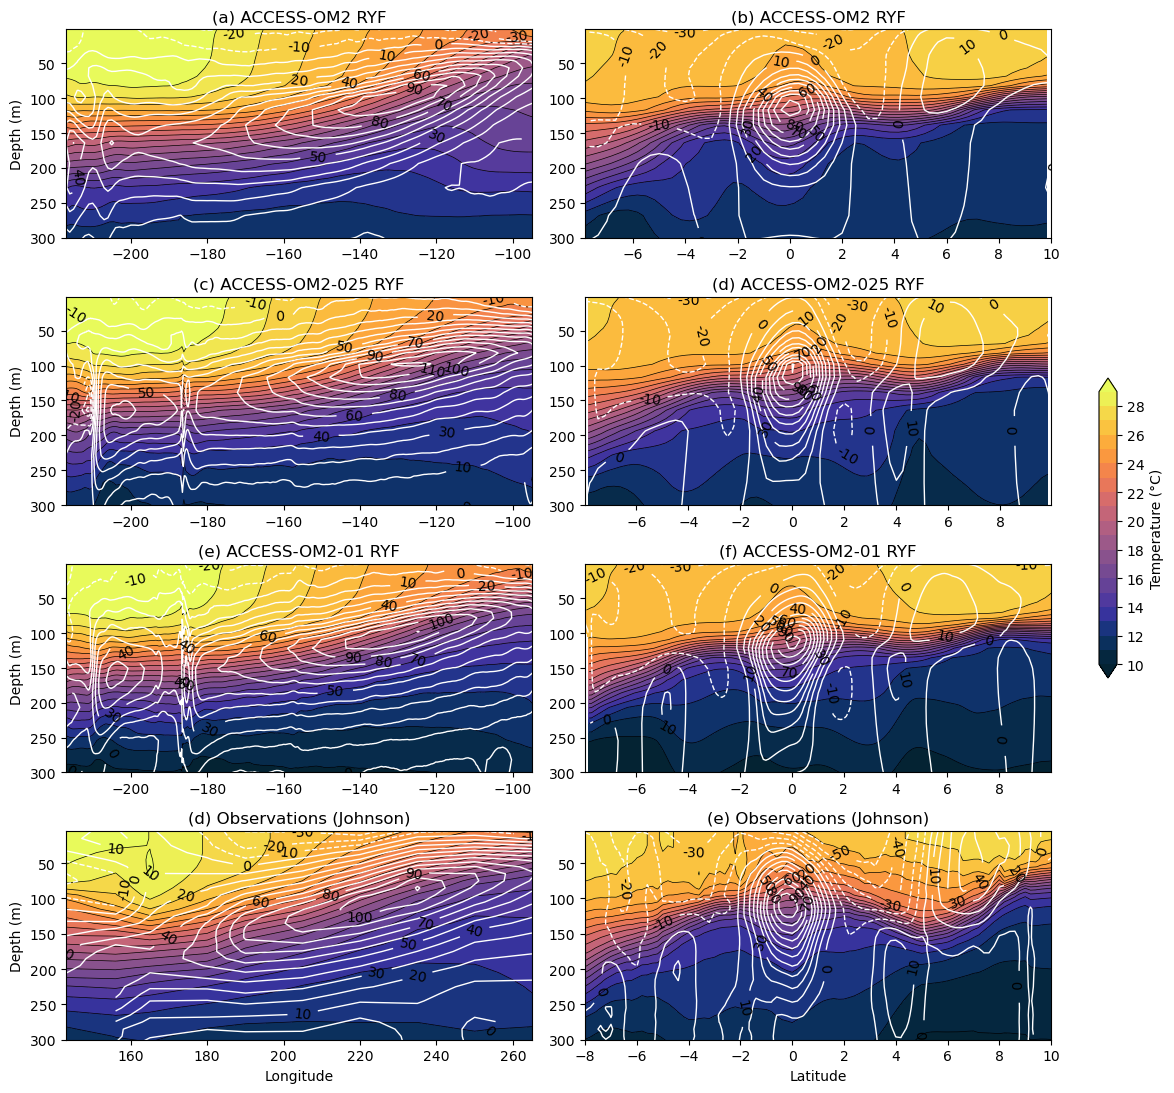

In [9]:
# Define colobar limits and labels:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

labels = ['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ', '(g) ','(h) ']

fig = plt.figure(figsize = (12,12))

# Select only a few runs for testing:
ekeys = ['1degRYF', '025degRYF', '01degRYF']

# Loop over experiments:
for i, ekey in enumerate(ekeys):

    # Plot equatorial slice:
    plt.subplot(4, 2, 2*i+1)
    p1=upper_temp_eq[ekey].plot.contourf(cmap = cm.cm.thermal, 
                                         levels = clevelsT,
                                         add_colorbar = False, extend = 'both')
    upper_temp_eq[ekey].plot.contour(colors = 'k', levels = clevelsT,
                                     add_colorbar = False, linewidths = 0.5)
    p2=upper_u_eq[ekey].plot.contour(colors='w', levels=clevelsU, linewidths=1)
    plt.clabel(p2, fmt = '%2.0f', colors = 'black', fontsize = 10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title(labels[2*i] + exp_dict[ekey]['long_name'])
    plt.ylim(300, None)
    plt.xlim(-217, -95)
    
    # Plot latitude-depth slice:
    plt.subplot(4, 2, 2*(i+1))
    p3=upper_temp_140w[ekey].plot.contourf(cmap = cm.cm.thermal, 
                                           levels = clevelsT,
                                           add_colorbar = False, extend = 'both')
    upper_temp_140w[ekey].plot.contour(colors = 'k', levels = clevelsT,
                                       add_colorbar = False, linewidths = 0.5)
    p4=upper_u_140w[ekey].plot.contour(colors = 'w', levels = clevelsU, linewidths = 1)
    plt.clabel(p4, fmt = '%2.0f', colors = 'black', fontsize = 10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(labels[2*i+1] + exp_dict[ekey]['long_name'])
    plt.ylim(300, None)

# Plot observational equatorial slice:
plt.subplot(4, 2, 7)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT, linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1, levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
i=i+1
plt.title(labels[i] + 'Observations (Johnson)')
plt.ylim(300, None)

# Plot observational latitude-depth slice:
plt.subplot(4, 2, 8)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('')
i=i+1
plt.title(labels[i] + 'Observations (Johnson)')
plt.ylim(300, None)

# Add colorbar:
ax3 = plt.axes([0.92, 0.38, 0.015, 0.25])
cb = plt.colorbar(p1, cax=ax3, orientation = 'vertical', extend='both')
cb.ax.set_ylabel('Temperature (°C)')
fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])

### Plot longitude-depth temperature bias to WOA13

Here we plot the equatorial longitude-depth temperature bias to the WOA13 data set. I.e. we plot the model temperature minus the WOA13 temperature.

The WOA13 data has already been interpolated onto the various model grids and is contained in the folder `/g/data/ik11/observations/woa13/`.

In [10]:
directory_list=['/g/data/ik11/observations/woa13/10_KDS50',
                '/g/data/ik11/observations/woa13/025_KDS50',
                '/g/data/ik11/observations/woa13/01']

In [11]:
# First copy the dictionary:
woa = {}
woa['1deg'] = xr.open_mfdataset(np.sort(glob.glob(directory_list[0]+'/*.nc')))
woa['025deg'] = xr.open_mfdataset(np.sort(glob.glob(directory_list[1]+'/*.nc')))
woa['01deg'] = xr.open_mfdataset(np.sort(glob.glob(directory_list[2]+'/*.nc')))

Calculate the anomalies:

In [12]:
# Loop through models
eq_temp_anom = {}
woa_eq_cross_section = {}
for ekey in list(woa.keys()):
    
    woa_eq_cross_section[ekey] = woa[ekey].sel(GRID_Y_T=0., method='nearest').mean('time')
    woa_eq_cross_section[ekey] = woa_eq_cross_section[ekey].rename({'ZT': 'st_ocean', 'GRID_X_T': 'xt_ocean'})
    woa_eq_cross_section[ekey] = woa_eq_cross_section[ekey].isel(st_ocean = slice(None, len(upper_temp_eq[ekey+'RYF']['st_ocean'])))
    woa_eq_cross_section[ekey]['st_ocean'] = upper_temp_eq[ekey+'RYF']['st_ocean'].values
    woa_eq_cross_section[ekey] = woa_eq_cross_section[ekey].sel(xt_ocean = upper_temp_eq[ekey+'RYF']['xt_ocean'])
    eq_temp_anom[ekey] = upper_temp_eq[ekey+'RYF'] - woa_eq_cross_section[ekey]['temp']

Next we define a function that plots the bias for a given set of models

In [13]:
# Plot Equatorial Slices:
def plot_eq(ekeys):
    
    # Define contour levels
    clev = np.arange(-3, 3.25, 0.25)

    # Loop through models
    for i, ekey in enumerate(ekeys):
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)),2,i+1)

        # Plot bias as color
        pn = eq_temp_anom[ekey].plot.contourf(cmap='bwr', levels=clev,
                                              add_colorbar=False, yincrease=False)
        
        # Plot WOA13 isotherms (and 20C bold)
        CS = woa_eq_cross_section[ekey]['temp'].plot.contour(levels=np.arange(0, 32, 2), colors='k')
        ax1.clabel(CS, inline=False, fmt='%d', fontsize=15)
        woa_eq_cross_section[ekey]['temp'].plot.contour(levels=[20.], colors='k', linewidths=3.)
        (eq_temp_anom[ekey]+woa_eq_cross_section[ekey]['temp'].values).plot.contour(levels=[20.],
                                                                                    scolors='k',
                                                                                    linewidths=3,
                                                                                    slinestyles='--')
        
        # Add annotations
        plt.title(exp_dict[ekey+'RYF']['long_name'])
        ax1.set_ylim([300, 0])
        ax1.set_xlim([-220, -80])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')
        if i==0:
            ax1.text(-210, 275, 'WOA13 Isotherms', fontsize=15)
            p0=pn;

    # Add colorbar
    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Temperature anomaly (°C)')

Finally, actually plot some runs

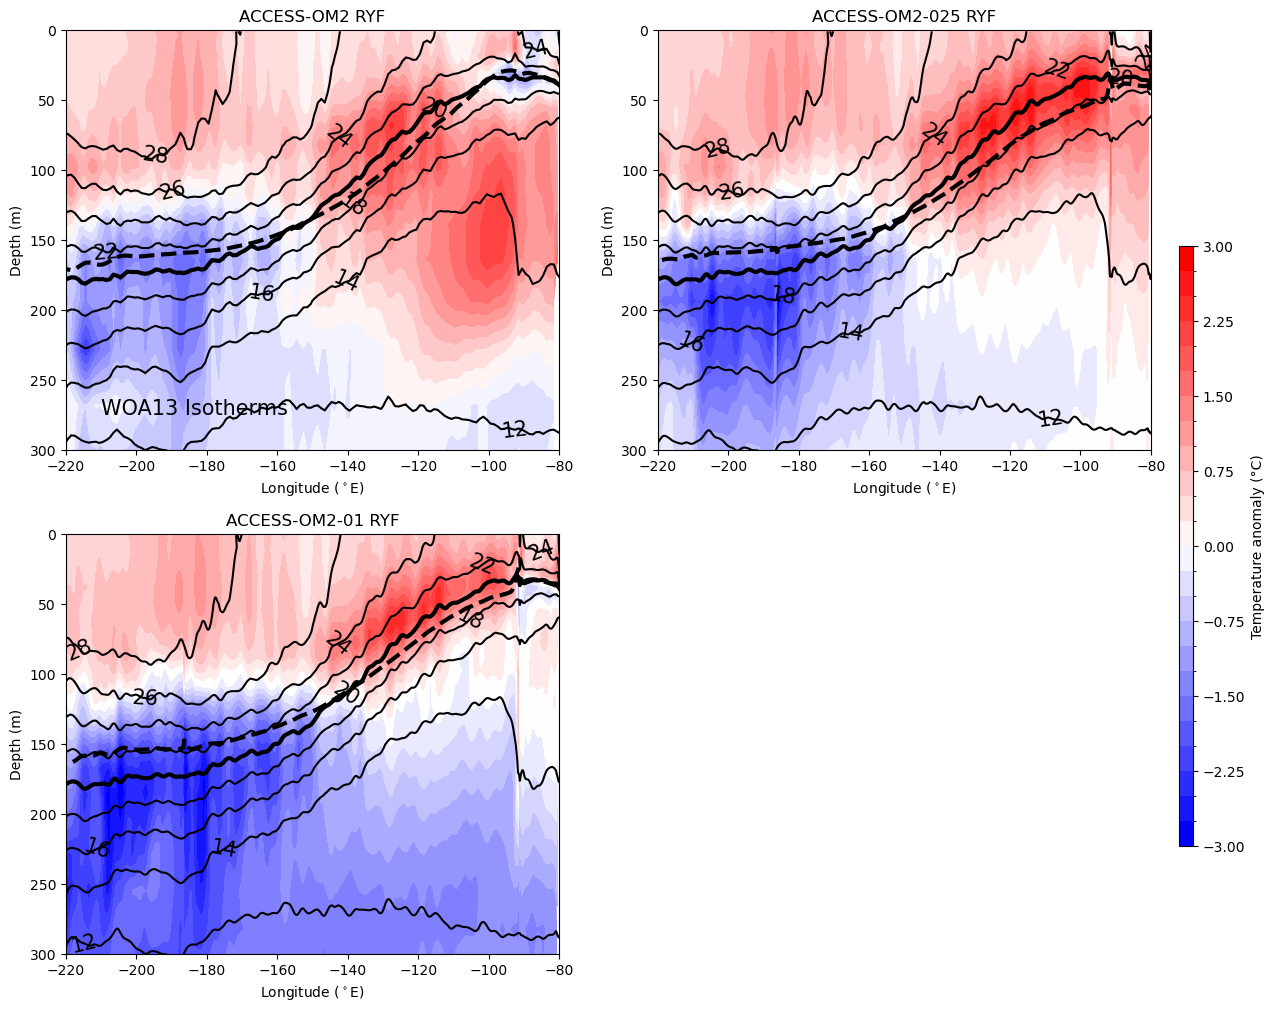

In [14]:
# Compare RYF simulations
fig = plt.figure(figsize=(14, 12))
ekeys = ['1deg', '025deg', '01deg']
plot_eq(ekeys)

### Plot vertical profiles at the Equator compared to TAO, Johnson and WOA13 data

Here we plot vertical profiles of temperature and zonal velocity from the models and compare to the TAO, Johnson and WOA13 data sets.

The TAO data can be downloaded from https://www.pmel.noaa.gov/tao/drupal/disdel/ and for the locations listed below is sitting in `/g/data/ik11/observations/TAO` directory.

We start out by defining functions to extract profiles from a given longitude from WOA13, TAO and the Johnson data. 


In [15]:
# TAO data extraction function:
obs_th = 2500 # This criteria denotes the minimum number of observations at a given depth required to include this point in the comparison.
def get_TAO(lonTAO):
    # Load temperature:
    tao_file_temp = xr.open_dataset('/g/data/ik11/observations/TAO/t0n' + lonTAO + '_dy.cdf')
    tao_temp = tao_file_temp['T_20'].isel(lon=0).isel(lat=0).sel(depth=slice(0, 400))
    tao_temp = tao_temp.where(tao_temp!=1.e35)
    count = np.count_nonzero(~np.isnan(tao_temp), axis=0)
    tao_temp = tao_temp.isel(depth=count>=obs_th) # Only average if more than x observations at given depth
    
    # Load zonal velocity from ADCP data:
    tao_file_u = xr.open_dataset('/g/data/ik11/observations/TAO/adcp0n' + lonTAO + '_dy.cdf')
    tao_u = tao_file_u['u_1205'].isel(lon=0).isel(lat=0).sel(depth=slice(0, 400)) / 100
    tao_u = tao_u.where(abs(tao_u)<=100.)
    count = np.count_nonzero(~np.isnan(tao_u), axis=0)
    tao_u = tao_u.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth

    # Load zonal velocity from current data:
    tao_file_uc = xr.open_dataset('/g/data/ik11/observations/TAO/cur0n' + lonTAO + '_dy.cdf')
    tao_uc = tao_file_uc['U_320'].isel(lon=0).isel(lat=0).sel(depth=slice(0, 400)) / 100
    tao_uc = tao_uc.where(abs(tao_uc)<=100)
    count = np.count_nonzero(~np.isnan(tao_uc), axis=0)
    tao_uc = tao_uc.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth
    
    return tao_temp, tao_u, tao_uc

# Johnson data function:
def get_Joh(lonJoh):
    joh_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')
    joh_temp = joh_file['POTEMPM']
    joh_u = joh_file['UM']

    joh_temp_eq = joh_temp.sel(ZDEP1_50=slice(0, 400)).sel(YLAT11_101=0, method='nearest').sel(XLON=lonJoh, method='nearest')
    joh_u_eq = joh_u.sel(ZDEP1_50=slice(0, 400)).sel(YLAT11_101=0, method='nearest').sel(XLON=lonJoh, method='nearest')
    dep_joh = joh_temp_eq.ZDEP1_50
    
    return joh_temp_eq, joh_u_eq, dep_joh
    
# WOA data function:
def get_WOA(lonWOA):
    
    temp_WOA13_10 = woa['025deg'].mean('time').sel(GRID_Y_T=0., method='nearest')
    woa_temp_eq = temp_WOA13_10.sel(GRID_X_T=lonWOA, method='nearest')['temp']
    
    return woa_temp_eq

Next we define a function to extract data from the models at a given longitude

In [16]:
def find_Eqpt(ekey,lon):

    temp_eq = upper_temp_eq[ekey].sel(xt_ocean=lon, method='nearest')
    u_eq = upper_u_eq[ekey].sel(xu_ocean=lon, method='nearest')
    
    return temp_eq, u_eq

Next we define the different longitudes that we wish to plot (since each dataset uses a different type of longitude):

In [17]:
# Define longitudes
lons = {'165e': {'mod': -195, 'tao': '165e', 'joh': 165, 'woa': -195},
        '140w': {'mod': -140, 'tao': '140w', 'joh': 220, 'woa': -140},
        '110w': {'mod': -110, 'tao': '110w', 'joh': 250, 'woa': -110}
        }

Finally, lets plot some profiles

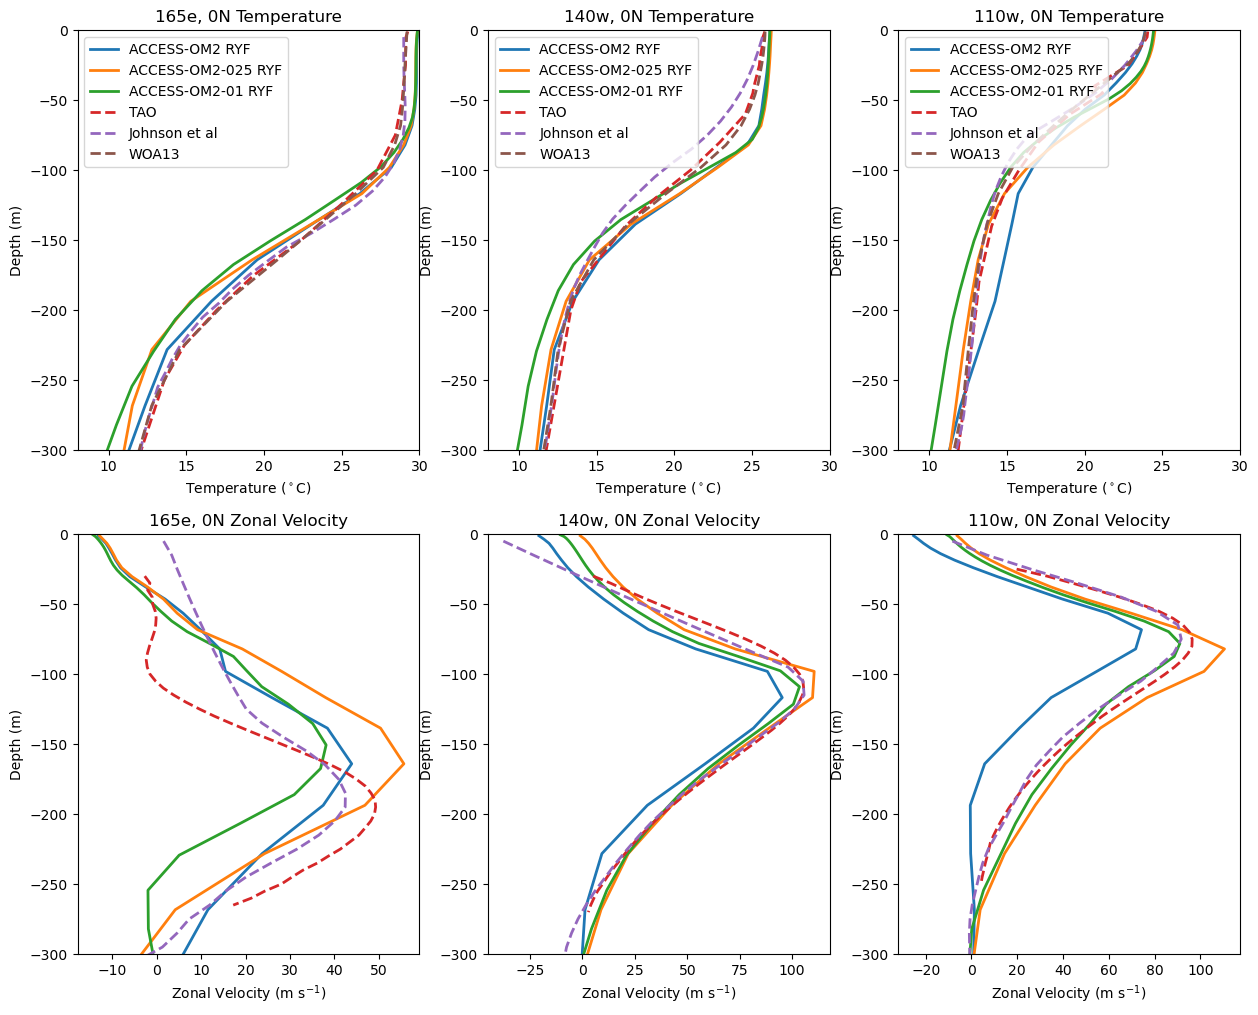

In [18]:
f = plt.figure(figsize=(15,12),facecolor='white')

ekeys = ['1degRYF','025degRYF','01degRYF']
nln = len(lons)
tax = []
uax = []
for j, lkey in enumerate(lons.keys()):
         
    tax.append(plt.subplot(2, nln, j+1))
    uax.append(plt.subplot(2, nln, j+nln+1))

    # Loop through and plot models:
    for i, ekey in enumerate(ekeys):
        t_eq, u_eq = find_Eqpt(ekey, lons[lkey]['mod'])
        tax[j].plot(t_eq.values, -t_eq.st_ocean.values, label=exp_dict[ekey]['long_name'], linewidth=2)
        uax[j].plot(u_eq.values, -u_eq.st_ocean.values, linewidth=2)

    # Extract observational data
    tao_temp, tao_u, tao_uc = get_TAO(lons[lkey]['tao'])
    joh_temp_eq, joh_u_eq, dep_joh = get_Joh(lons[lkey]['joh'])
    woa_temp_eq = get_WOA(lons[lkey]['woa'])
    
    # Ploty observational temperatures
    tax[j].plot(tao_temp.mean('time'), -tao_temp.depth, '--', linewidth=2, label='TAO')
    tax[j].plot(joh_temp_eq, -dep_joh, '--', linewidth=2 ,label='Johnson et al')
    tax[j].plot(woa_temp_eq.values, -woa_temp_eq.ZT.values, '--', linewidth=2, label='WOA13')
    tax[j].set_xlabel('Temperature ($^\circ$C)')
    tax[j].set_ylabel('Depth (m)')
    tax[j].legend(loc=2)
    tax[j].set_ylim([-300, 0])
    tax[j].set_xlim([8, 30])
    tax[j].set_title(lons[lkey]['tao'] + ', 0N Temperature')
 
    # Plot observational zonal velocities (note, there is no U data from WOA13)
    uax[j].plot(tao_u.mean('time') * 100, -tao_u.depth, '--', linewidth=2) # ADCP data
    # uax[j].plot(tao_uc.mean('time') * 100, -tao_uc.depth, ':', linewidth=2) # Current meter data
    uax[j].plot(joh_u_eq * 100, -dep_joh, '--', linewidth=2)
    uax[j].set_xlabel('Zonal Velocity (m s$^{-1}$)')
    uax[j].set_ylabel('Depth (m)')
    uax[j].set_ylim([-300, 0])
    uax[j].set_title(lons[lkey]['tao'] + ', 0N Zonal Velocity')

### Seasonal cycle of SST and zonal velocity along the Equator

Finally, we show an example of plotting a Hovemoeller plot of the seasonal cycle of temperature and zonal velocity against observations. This uses the `groupby` function to calculate a climatology for each variable.

First, define a function to extract the model data and take a climatology and the climatological anomaly

In [19]:
depth = 0. # [m]
lats = slice(-5., 5.) # latitude range to average over [degrees]
lons = slice(-217, -95) # longitude range to plot [degrees]

def find_hov(ekey):
    expt = exp_dict[ekey]['experiment']
    ds = catalog[expt].search(variable = 'temp', frequency = '1mon').to_dask(xarray_open_kwargs = {'use_cftime': True})
    darray = ds['temp'].sel(time = exp_dict[ekey]['time_bounds']) - 273.15
    darray = darray.sel(st_ocean = depth, method = 'nearest').sel(yt_ocean = lats, xt_ocean = lons).mean('yt_ocean')
    
    temp_tot = darray.groupby('time.month').mean('time').load()
    temp_tot.attrs['units'] = 'degrees Celsius'
    temp_anom = temp_tot - darray.mean('time')
    
    ds = catalog[expt].search(variable = 'u', frequency = '1mon').to_dask(xarray_open_kwargs = {'use_cftime': True})
    darray = ds['u'].sel(time = exp_dict[ekey]['time_bounds']) * 100
    darray = darray.sel(st_ocean = depth, method = 'nearest').sel(yu_ocean = lats, xu_ocean = lons).mean('yu_ocean')    

    u_tot = darray.groupby('time.month').mean('time').load() 
    u_tot.attrs['units'] = 'cms-1'
    u_anom = u_tot - darray.mean('time')
    
    return temp_tot, temp_anom, u_tot, u_anom

Next, get the observations, first WOA13 temperature:

In [20]:
temp_WOA13 = woa['025deg'].sel(GRID_Y_T=lats).mean('GRID_Y_T').sel(ZT=depth,method='nearest').sel(GRID_X_T=lons)['temp']
temp_WOA13_anom = temp_WOA13 - temp_WOA13.mean('time')

Next, zonal surface velocity from drifters. The drifter data set is taken from:

Laurindo, L., A. Mariano, and R. Lumpkin, 2017: An improved near-surface velocity climatology for the global ocean from drifter observations Deep-Sea Res. I, 124, pp.73-92, doi:10.1016/j.dsr.2017.04.009 .

And is currently in `/g/data/hh5/tmp/cosima/observations/original/drifter_monthlymeans.nc`

In [21]:
obs_file = xr.open_dataset('/g/data/hh5/tmp/cosima/observations/original/drifter_monthlymeans.nc').rename({'Lat': 'latitude','Lon': 'longitude'})
obs_u = obs_file['U']

# latitude: 5S-5N, longitude: 45E-100E
obs_u_eq = obs_u.sel(latitude=lats).sel(longitude=lons)
m_obs_u_eq = obs_u_eq.mean('latitude')
a_obs_u_eq = np.ma.anom(m_obs_u_eq, axis=1)
new_a_obs_u_eq = np.transpose(a_obs_u_eq)

Finally, we plot the SST hovmoller and the zonal velocity hovmoeller

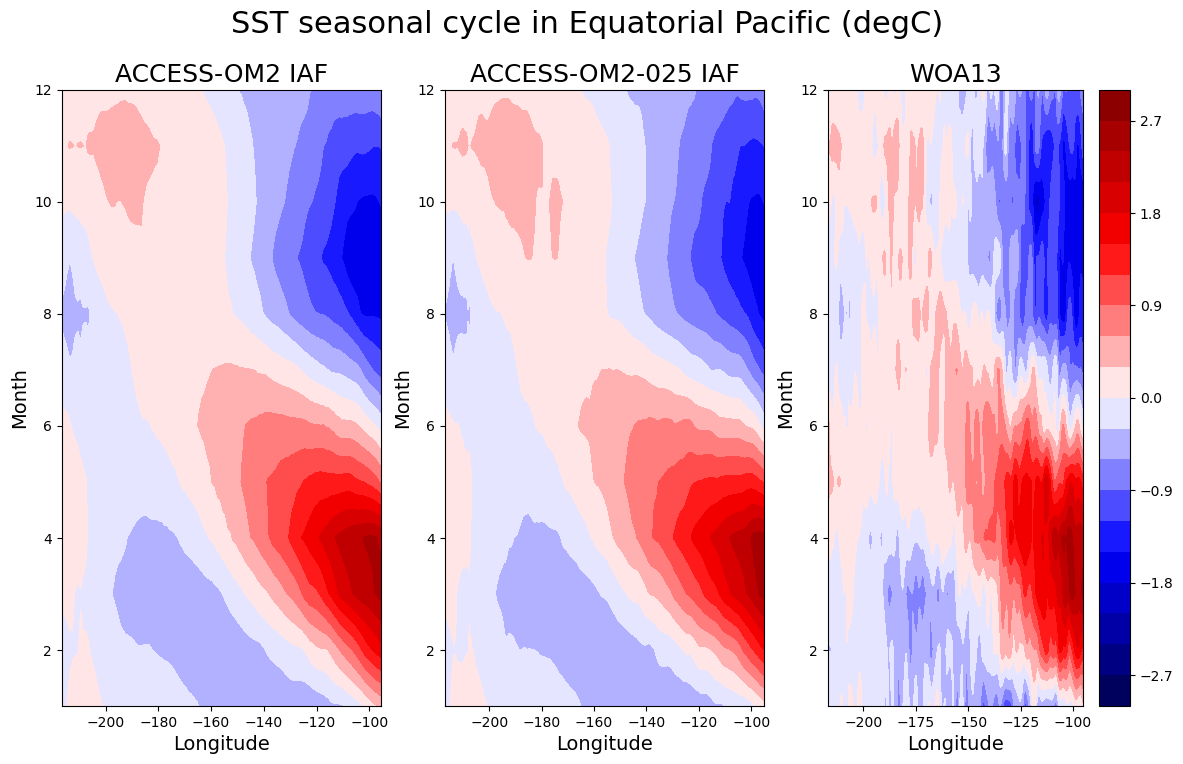

In [22]:
# Plot SST hovmoeller against WOA13
Tmax = 3
Tmin = -Tmax
delT = 0.3
clevels = np.arange(Tmin, Tmax+delT, delT)

fig = plt.figure(figsize=(14, 8))

ekeys = ['1degIAF','025degIAF']

for i, ekey in enumerate(ekeys):
    temp_tot, temp_anom, u_tot, u_anom = find_hov(ekey)

    ax = plt.subplot(1, 3, i+1)
    cax = plt.contourf(temp_tot.xt_ocean, temp_tot.month, temp_anom,
                       levels=clevels, cmap=plt.cm.seismic)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Month', fontsize=14 )
    ax.set_title(exp_dict[ekey]['long_name'], fontsize=18)

ax = plt.subplot(1,3,3)
cax = ax.contourf(temp_WOA13.GRID_X_T, np.arange(12)+1, temp_WOA13_anom,
                  levels=clevels, cmap=plt.cm.seismic)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Month', fontsize=14)
ax.set_title('WOA13', fontsize=18)
cbar = plt.colorbar(cax)

fig.suptitle('SST seasonal cycle in Equatorial Pacific (degC)', fontsize=22);

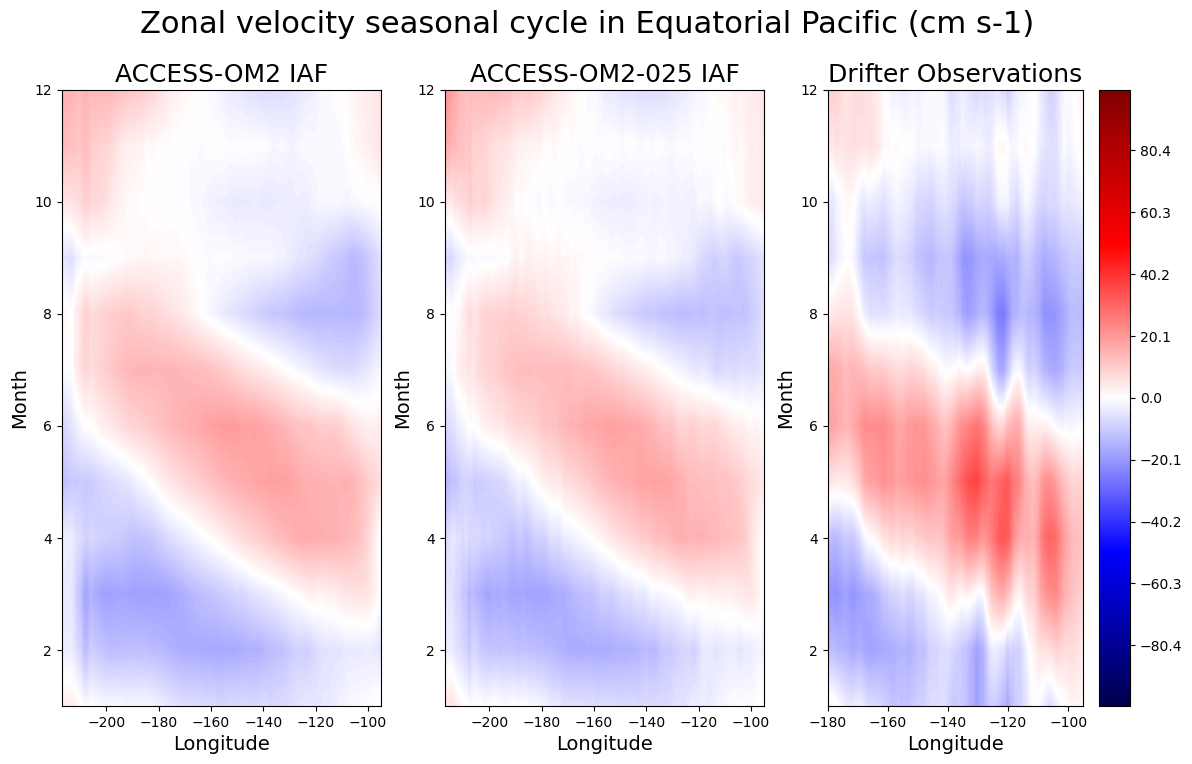

In [23]:
# Plot Zonal velocity hovmoeller:
Tmax = 100.0
Tmin = -Tmax
delT = 0.1

clevels = np.arange(Tmin, Tmax+delT, delT)

fig = plt.figure(figsize=(14, 8))

ekeys = ['1degIAF', '025degIAF']

for i, ekey in enumerate(ekeys):
    temp_tot, temp_anom, u_tot, u_anom = find_hov(ekey)

    ax = plt.subplot(1, 3, i+1)
    cax = plt.contourf(u_tot.xu_ocean, u_tot.month, u_anom,
                       levels=clevels, cmap=plt.cm.seismic)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Month', fontsize=14 )
    ax.set_title(exp_dict[ekey]['long_name'], fontsize=18)

ax = plt.subplot(1, 3, 3)
cax = ax.contourf(obs_u_eq.longitude, np.arange(12)+1, new_a_obs_u_eq * 100,
                  levels=clevels, cmap=plt.cm.seismic )
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Month', fontsize=14 )
cbar = plt.colorbar(cax)
ax.set_title('Drifter Observations', fontsize=18)

fig.suptitle('Zonal velocity seasonal cycle in Equatorial Pacific (cm/s)', fontsize=22);